In [1]:
import requests
import json
from scipy import stats
import matplotlib.pyplot as plt

### This code accesses Google Ngrams to compare the frequencies of two N-grams and determines whether the difference is statistically significant.

Only some corpora are supported in this version. All are 2019 versions.

In [2]:
corpora = {'English': 26, 
           'French': 30, 
           'German': 31,
           'Italian': 33,
           'Russian': 36,
           'Spanish': 32
          }

Available languages: English, French, German, Italian, Russian, Spanish
Enter language: Russian
Enter the start year (1500-2018): 2000
Enter the end year (1501-2019): 2019
Entern the first N-gram. No more than 5 words. No punctuation, characters only! как бы то ни было
Do you want your search for the first N-gram to be case INSENSITIVE. Enter Y for yes or N for no: Y
Entern the second N-gram. No more than 5 words. No punctuation, characters only! как бы там ни было
Do you want your search for the second N-gram to be case INSENSITIVE. Enter Y for yes or N for no: Y
Enter significance level (0 < alpha < 1). If not sure, enter 0 for the defalut value of 0.05: 0


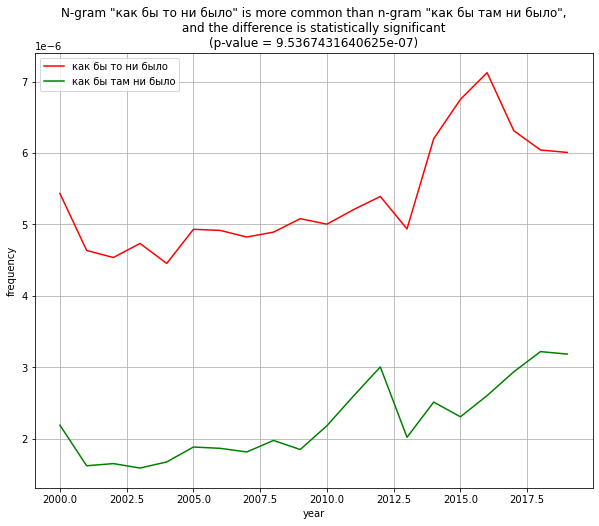

Do you want to try other phrases. Enter Y for yes or N for no: Y
Available languages: English, French, German, Italian, Russian, Spanish
Enter language: English
Enter the start year (1500-2018): 1900
Enter the end year (1501-2019): 2000
Entern the first N-gram. No more than 5 words. No punctuation, characters only! Sherlock Holmes
Do you want your search for the first N-gram to be case INSENSITIVE. Enter Y for yes or N for no: Y
Entern the second N-gram. No more than 5 words. No punctuation, characters only! Frankenstein
Do you want your search for the second N-gram to be case INSENSITIVE. Enter Y for yes or N for no: Y
Enter significance level (0 < alpha < 1). If not sure, enter 0 for the defalut value of 0.05: 0


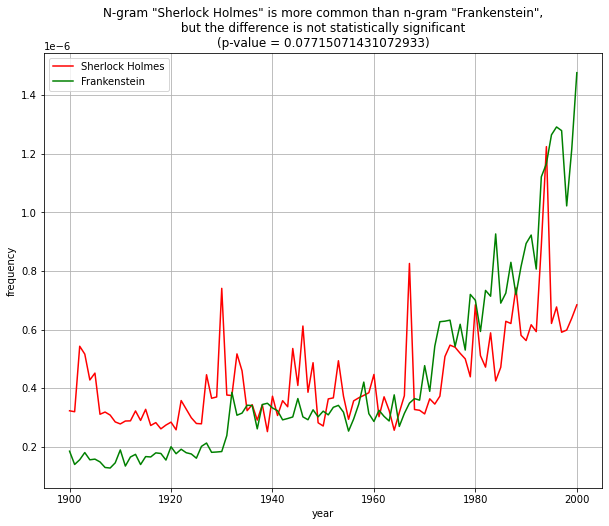

Do you want to try other phrases. Enter Y for yes or N for no: N


In [10]:
# Condition for running the comparison cycle
another_comparison = 'Y'

while another_comparison == 'Y':

    # Language selection:
    not_selected = True
    while not_selected:
        print('Available languages:', ', '.join(corpora.keys()))
        lang = input('Enter language: ')
        if lang in corpora:
            not_selected = False
        else:
            print('This language is not supported. Try again')

    # Time interval selection
    not_selected = True
    while not_selected:
        year_start = int(input('Enter the start year (1500-2018): '))
        if year_start < 1500 or year_start > 2018:
            print('Year out of the available interval. Try again')
        else:
            not_selected = False

    not_selected = True
    while not_selected:
        year_end = int(input('Enter the end year (1501-2019): '))
        if year_end < 1501 or year_end > 2019:
            print('Year out of the available interval. Try again')
        elif year_start >= year_end:
            print('Start later than end. Try again')
        else:
            not_selected = False

    # First N-gram
    no_data = True
    while no_data:
        not_selected = True
        while not_selected:
            ngram_1 = input('Entern the first N-gram. No more than 5 words. No punctuation, characters only! ')
            if  len(ngram_1.split()) > 5:
                print('N-gram too long. Try again')
            else:
                not_selected = False

        # Case sensitive?
        not_selected = True
        while not_selected:
            case_insensitive_1 = input('Do you want your search for the first N-gram to be case INSENSITIVE. Enter Y for yes or N for no: ')
            if  case_insensitive_1 != 'Y' and case_insensitive_1 != 'N':
                print('Wrong answer. Try again')
            else:
                not_selected = False

        params_1 = {
            'content': ngram_1,
            'year_start': year_start,
            'year_end': year_end,
            'corpus': corpora[lang],
            'smoothing': 0
        }
        if case_insensitive_1 == 'Y':
            params_1['case_insensitive'] = 'true'

        result_1 = requests.get('https://books.google.com/ngrams/json?', params=params_1).json()
        if len(result_1) == 0:
            print("N-gram not found. Try again (check capitalization)")
        else:
            result_1 = result_1[0]['timeseries']
            no_data = False

    # Second N-gram
    no_data = True
    while no_data:
        not_selected = True
        while not_selected:
            ngram_2 = input('Entern the second N-gram. No more than 5 words. No punctuation, characters only! ')
            if  len(ngram_2.split()) > 5:
                print('N-gram too long. Try again')
            else:
                not_selected = False

        # Case sensitive?
        not_selected = True
        while not_selected:
            case_insensitive_2 = input('Do you want your search for the second N-gram to be case INSENSITIVE. Enter Y for yes or N for no: ')
            if  case_insensitive_2 != 'Y' and case_insensitive_2 != 'N':
                print('Wrong answer. Try again')
            else:
                not_selected = False
        params_2 = {
            'content': ngram_2,
            'year_start': year_start,
            'year_end': year_end,
            'corpus': corpora[lang],
            'smoothing': 0
        }        
        if case_insensitive_2 == 'Y':
            params_2['case_insensitive'] = 'true'

        result_2 = requests.get('https://books.google.com/ngrams/json?', params=params_2).json()
        if len(result_2) == 0:
            print("N-gram not found. Try again (check capitalization)")
        else:
            result_2 = result_2[0]['timeseries']
            no_data = False

    # Significance level
    not_selected = True
    while not_selected:
        alpha = float(input('Enter significance level (0 < alpha < 1). If not sure, enter 0 for the defalut value of 0.05: '))
        if alpha < 0 or alpha >= 1:
            print('Error. Enter a number between 0 and 1')
        elif alpha == 0:
            alpha = 0.05
            not_selected = False
        else:
            not_selected = False

    sum1 = sum(result_1)
    sum2 = sum(result_2)
    if sum1 == sum2:
        outcome = 'No difference'
    else:
        if sum1 > sum2:
            more_common = ngram_1
            less_common = ngram_2
            compare = stats.wilcoxon(result_1, result_2, alternative='greater')
        else:
            more_common = ngram_2
            less_common = ngram_1    
            compare = stats.wilcoxon(result_1, result_2, alternative='less')

        if compare.pvalue < alpha:
            significance = 'and the difference is statistically significant'
        else:
            significance = 'but the difference is not statistically significant'

        outcome = 'N-gram "{0}" is more common than n-gram "{1}",\n {2} \n(one-sided Wilcoxon rank-sum test, p-value = {3})'.format(more_common, 
                                                                                        less_common, 
                                                                                        significance, 
                                                                                        compare.pvalue) 

    year_range = list(range(year_start, year_end + 1))
    plt.figure(figsize=(10, 8))
    plt.plot(year_range, result_1, color='r', label=ngram_1)
    plt.plot(year_range, result_2, color='g', label=ngram_2)
    plt.xlabel("year")
    plt.ylabel("frequency")
    plt.title(outcome)
    plt.legend()
    plt.grid()
    plt.show()

                                                                                          
    # Another comparison?
    not_selected = True
    while not_selected:
        another_comparison = input('Do you want to try other phrases. Enter Y for yes or N for no: ')
        if  another_comparison != 'Y' and another_comparison != 'N':
            print('Wrong answer. Try again')
        else:
            not_selected = False